In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from typing import List
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss
import sys


sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
RAW_DATA_PATH = "../datasets/fraud/vehicle_fraud.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_csv(RAW_DATA_PATH)
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
print(df.shape[0])
df["fraud_found_p"].value_counts()/df.shape[0]*100

pd.set_option('display.max_columns', None)

df.head()

15420


,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,policy_number,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,address_change_claim,number_of_cars,year,base_policy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
df.isna().any()

month                    False
week_of_month            False
day_of_week              False
make                     False
accident_area            False
day_of_week_claimed      False
month_claimed            False
week_of_month_claimed    False
sex                      False
marital_status           False
age                      False
fault                    False
policy_type              False
vehicle_category         False
vehicle_price            False
fraud_found_p            False
policy_number            False
rep_number               False
deductible               False
driver_rating            False
days_policy_accident     False
days_policy_claim        False
past_number_of_claims    False
age_of_vehicle           False
age_of_policy_holder     False
police_report_filed      False
witness_present          False
agent_type               False
number_of_suppliments    False
address_change_claim     False
number_of_cars           False
year                     False
base_pol

In [4]:
df.value_counts(["make", "fraud_found_p"])

make       fraud_found_p
Pontiac    0                3624
Toyota     0                2935
Honda      0                2622
Mazda      0                2231
Chevrolet  0                1587
Ford       0                 417
Accura     0                 413
VW         0                 275
Pontiac    1                 213
Toyota     1                 186
Honda      1                 179
Mazda      1                 123
Dodge      0                 107
Saab       0                  97
Chevrolet  1                  94
Mercury    0                  77
Accura     1                  59
Saturn     0                  52
Ford       1                  33
Nisson     0                  29
BMW        0                  14
Saab       1                  11
VW         1                   8
Mercury    1                   6
Jaguar     0                   6
Saturn     1                   6
Porche     0                   5
Mecedes    0                   3
Ferrari    0                   2
Dodge      1      

In [5]:
df[sorted(df.columns)].dtypes

accident_area            object
address_change_claim     object
age                       int64
age_of_policy_holder     object
age_of_vehicle           object
agent_type               object
base_policy              object
day_of_week              object
day_of_week_claimed      object
days_policy_accident     object
days_policy_claim        object
deductible                int64
driver_rating             int64
fault                    object
fraud_found_p             int64
make                     object
marital_status           object
month                    object
month_claimed            object
number_of_cars           object
number_of_suppliments    object
past_number_of_claims    object
police_report_filed      object
policy_number             int64
policy_type              object
rep_number                int64
sex                      object
vehicle_category         object
vehicle_price            object
week_of_month             int64
week_of_month_claimed     int64
witness_

In [6]:
df["fraud_found_p"].value_counts()/df.shape[0]*100

fraud_found_p
0    94.014267
1     5.985733
Name: count, dtype: float64

In [7]:
y = "fraud_found_p"

# some generic cleaning
df = df.loc[df.day_of_week_claimed!=0]
df = df.loc[df.policy_type!="Sport - Liability"]
df["vehicle_price"] = df["vehicle_price"].str.replace("less than ", "").str.replace("more than ", "").str.split(" to").str[0].astype(int)
df["past_number_of_claims"]= df["past_number_of_claims"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_claim"] = df["days_policy_claim"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_accident"] = df["days_policy_accident"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["age_of_vehicle"] = df["age_of_vehicle"].str.replace("new", "0").str.replace("more than ", "").str.split("").str[1].astype(int)
df["age_of_policy_holder"] = df["age_of_policy_holder"].str.replace("over ", "").str.split("").str[1:3].str.join("").astype(int)
df["address_change_claim"] = df["address_change_claim"].str.split("").str[1].str.replace("n", "0").str.replace("u", "0.25").astype(float)
df["number_of_suppliments"] = df["number_of_suppliments"].str.split("").str[1].str.replace("n", "0").str.replace("m", "5").astype(int)
df['number_of_cars'] = df.number_of_cars.str.split("").str[1].str.replace("m", "8")
df["number_of_cars_as_int"] = df["number_of_cars"].str.split("").str[1].str.replace("m", "8").astype(int)
COLUMNS_TO_DROP = ["address_change_claim", "number_of_cars", "policy_number"]
assert df[y].isna().any() == False
# drop single row with Lexus as encoder can't handle cases seen in only train, while encoding test
drop_condition = ((df.make.isin(["Lexus", "Ferrari", "Mecedes"])) | (
    df.make.isin(["BMW", "Nisson", "Mecedes", "Dodge"]) & (df[y] == 1)))
raw_features = df.drop(
    COLUMNS_TO_DROP, axis=1).loc[~drop_condition]

# ML tuning
# add make otherwise there are unknown brands in test set, and encoder can't handle
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=raw_features[[y, "make"]])

fit_le = LabelEncoder().fit(train[y])

In [8]:
df.shape[0] - raw_features.shape[0]

11

In [9]:
# def build_column_transformer_for_df(train_x: pd.DataFrame, text_columns:List[str]) -> ColumnTransformer:
#     """Builds a column transformer for a pandas dataframe."""
#     # Get the categorical and numerical columns
#     categorical_columns = train_x.select_dtypes(
#         include='object').columns.to_list()
#     numerical_columns = train_x.select_dtypes(
#         include='number').columns.to_list()

#     num_prep = Pipeline(steps=[
#         ('num_imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ])

#     cat_prep = Pipeline(steps=[
#         ('cat_imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(sparse_output=False))
#     ])

#     transformer = ColumnTransformer([
#         ('text', TfidfVectorizer(), text_columns),
#         ('num', num_prep, numerical_columns),
#         ('cat', cat_prep, categorical_columns)
#     ])

#     return transformer

In [10]:
# pipeline = build_sklearn_pipeline(train, y, model_name="logistic", model=LogisticRegression())
# pipeline.fit(train.drop(y, axis=1), train[y])

In [11]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 8)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

# text_columns = ["address_change_claim"]

# steps = build_column_transformer_for_df(
#     train_x=train.drop(y, axis=1))._transformers
# steps.insert(0, ('text', TfidfVectorizer(), [text_column]))
# preprocessor = ColumnTransformer(steps)

# preprocessor = build_column_transformer_for_df(train.drop(y, axis=1), text_columns)
# pipeline = build_sklearn_pipeline(
#     train, y_col_name=y, model_name=MODEL_NAME, model=model, transformer=preprocessor)
grid = sklearn_gridsearch_using_pipeline(train, y_col_name=y, model_name=MODEL_NAME,
                                  model=model, fit_le=fit_le, param_grid=param_grid, verbose=1, n_folds=5) #, pipeline=pipeline)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.7748771608686597
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 22, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                                                   'make', 'accident_area',
                                                   'day_of_week_claimed',
                                                   'month_claimed', 'sex',
                                                   'marital_status', 'fault',
                                                   'policy_type',
                                                   'vehicle_category',
                                                   'police_report_filed',
                                                   'witness_present',
                                                   'agent_type',
                                                   'base_policy'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=22)),
                ('logistic', LogisticRegression(C=100))])

In [12]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [13]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,6,1,l2,0.628045,0.020238
144,0.1,0.2,6,10,l2,0.630553,0.015963
288,0.1,0.2,6,100,l2,0.633226,0.015785
432,0.1,0.2,6,1000,l2,0.628221,0.013227
6,0.1,0.2,14,1,l2,0.638528,0.017794
...,...,...,...,...,...,...,...
568,0.7,1.0,22,1000,l2,0.768601,0.009653
142,0.7,1.0,30,1,l2,0.770545,0.004285
286,0.7,1.0,30,10,l2,0.767799,0.005414
430,0.7,1.0,30,100,l2,0.766983,0.006856


In [14]:
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [15]:
# To check if categorical values are in train but not in test 
categorical_columns = train.select_dtypes(
    include='object').columns.to_list()

for feature in categorical_columns:
    diff = set(train[feature]).difference(test[feature])
    if len(diff)>0:
        print(feature)

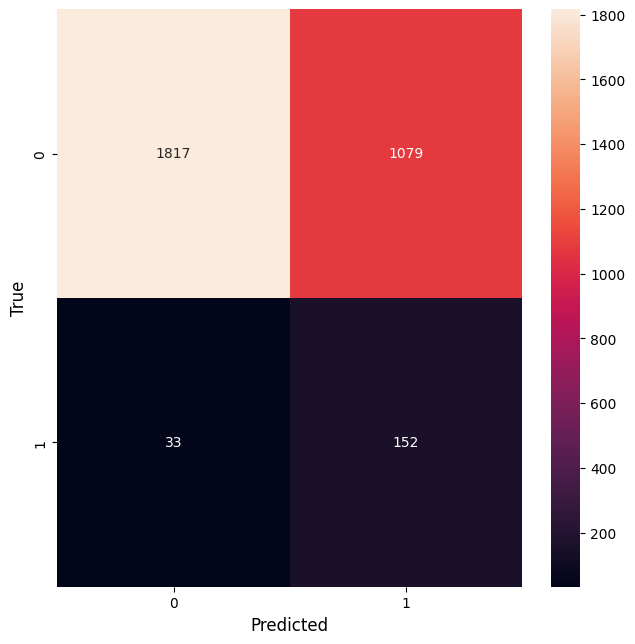

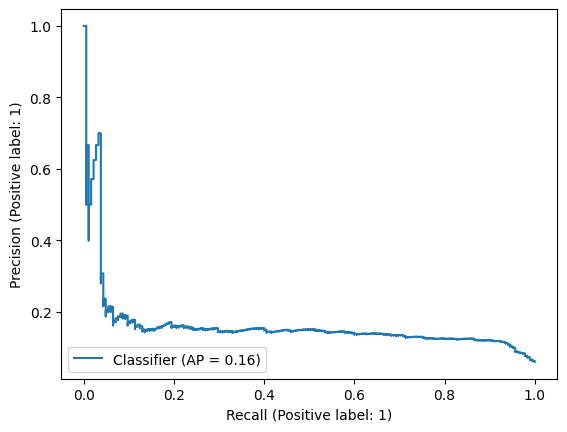

In [16]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)

evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=fixed_test_set, y_col_name=y, model_name= 'logistic')

In [17]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.7692765765210784
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.2, 'pca__n_components': 50, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [18]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

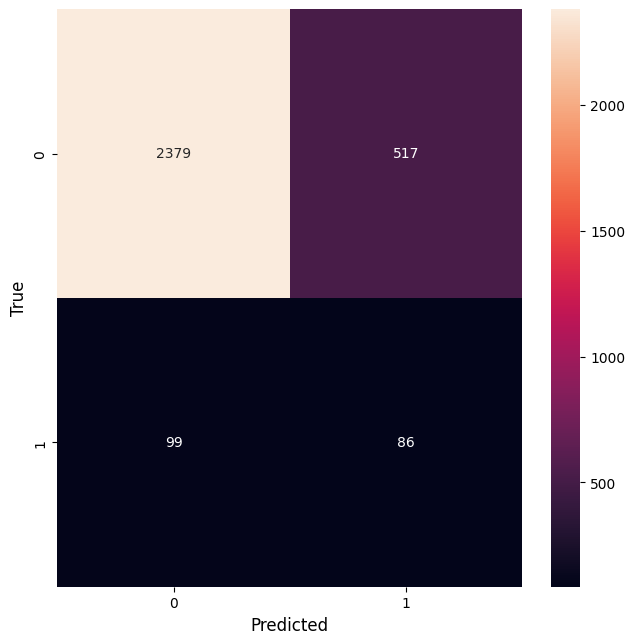

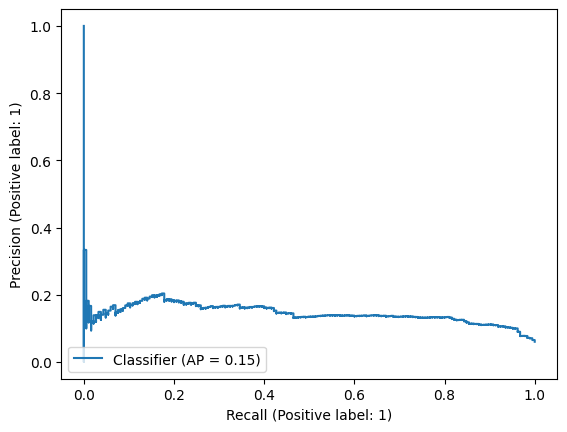

In [19]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)


evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=fixed_test_set, y_col_name=y, model_name=MODEL_NAME)

In [20]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [21]:
test = fixed_test_set

In [22]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 1719.
 total cost/loss average :  0.557935735150925


In [23]:
print(test['vehicle_price'].unique())

[69000 30000 20000 40000 60000]


In [24]:
print(test["fraud_found_p"].unique())

[0 1]


In [25]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 2019.
 total cost/loss average :  0.6553067185978578


In [26]:

print(test_predictions_xgb[['fraud_found_p', "A", 'instance_cost', 'y_predicted']].iloc[31:60])

    fraud_found_p        A  instance_cost  y_predicted
31              0  20000.0            0.0            0
32              0  20000.0            0.0            0
33              0  30000.0            0.0            0
34              0  60000.0            0.0            0
35              0  30000.0            0.0            0
36              0  20000.0            0.0            0
37              0  69000.0            0.0            0
38              0  20000.0            0.0            0
39              0  20000.0            0.0            0
40              0  20000.0            0.0            0
41              0  30000.0            0.0            0
42              0  20000.0            0.0            0
43              0  20000.0            0.0            0
44              0  20000.0            1.0            1
45              0  20000.0            0.0            0
46              0  69000.0            0.0            0
47              1  30000.0            0.0            1
48        

# amc metric


Decision Threshold: 0.01, Test cost/loss = 2854.00
Decision Threshold: 0.02, Test cost/loss = 2764.00


Decision Threshold: 0.03, Test cost/loss = 2741.00
Decision Threshold: 0.04, Test cost/loss = 2761.50
Decision Threshold: 0.05, Test cost/loss = 2741.50
Decision Threshold: 0.06, Test cost/loss = 2713.50
Decision Threshold: 0.07, Test cost/loss = 2676.50
Decision Threshold: 0.08, Test cost/loss = 2620.50
Decision Threshold: 0.09, Test cost/loss = 2571.00
Decision Threshold: 0.10, Test cost/loss = 2481.00
Decision Threshold: 0.11, Test cost/loss = 2374.00
Decision Threshold: 0.12, Test cost/loss = 2283.50
Decision Threshold: 0.13, Test cost/loss = 2172.50
Decision Threshold: 0.14, Test cost/loss = 2077.50
Decision Threshold: 0.15, Test cost/loss = 2003.50
Decision Threshold: 0.16, Test cost/loss = 1923.50
Decision Threshold: 0.17, Test cost/loss = 1829.50
Decision Threshold: 0.18, Test cost/loss = 1758.50
Decision Threshold: 0.19, Test cost/loss = 1718.50
Decision Threshold: 0.20, Test cost/loss = 1670.50
Decision Threshold: 0.21, Test cost/loss = 1626.50
Decision Threshold: 0.22, Test

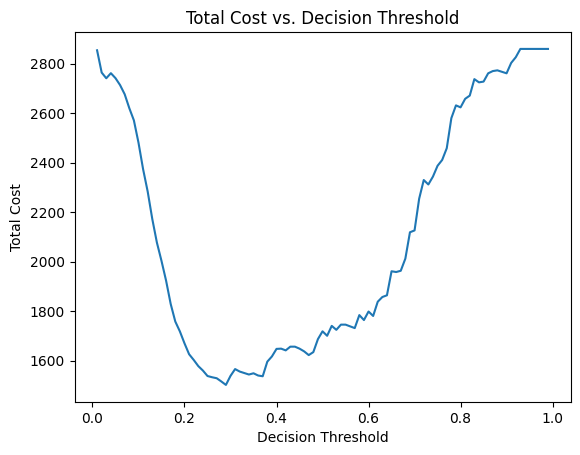

In [27]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 2622.50
Decision Threshold: 0.02, Test cost/loss = 2376.00
Decision Threshold: 0.03, Test cost/loss = 2220.00
Decision Threshold: 0.04, Test cost/loss = 2039.00
Decision Threshold: 0.05, Test cost/loss = 1942.00
Decision Threshold: 0.06, Test cost/loss = 1844.00
Decision Threshold: 0.07, Test cost/loss = 1760.00
Decision Threshold: 0.08, Test cost/loss = 1707.00
Decision Threshold: 0.09, Test cost/loss = 1694.50
Decision Threshold: 0.10, Test cost/loss = 1702.00
Decision Threshold: 0.11, Test cost/loss = 1666.00
Decision Threshold: 0.12, Test cost/loss = 1671.50
Decision Threshold: 0.13, Test cost/loss = 1736.50
Decision Threshold: 0.14, Test cost/loss = 1719.50
Decision Threshold: 0.15, Test cost/loss = 1705.50
Decision Threshold: 0.16, Test cost/loss = 1663.50
Decision Threshold: 0.17, Test cost/loss = 1642.50
Decision Threshold: 0.18, Test cost/loss = 1626.50
Decision Threshold: 0.19, Test cost/loss = 1596.50
Decision Threshold: 0.20, Test 

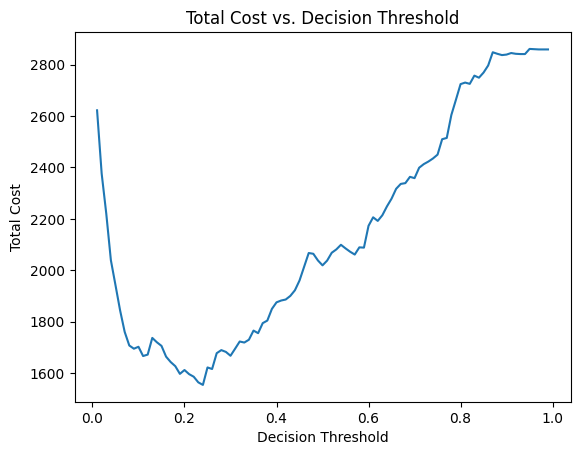

In [28]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud' )

# e-amc

In [29]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [30]:
test_predictions_log

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,1,0,69000.0,0.0,1,0.772731,0,34.5,1,0,0.772731,0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,1,0,30000.0,0.0,1,0.650338,0,15.0,1,0,0.650338,0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.126620,0,10.0,1,0,0.126620,0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.462978,0,15.0,1,0,0.462978,0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,1,0,20000.0,0.0,1,0.661373,0,10.0,1,0,0.661373,0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,1,1,20000.0,10.0,1,0.775970,0,10.0,1,0,2.240296,9.405322
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,10.0,0,0.499345,0,10.0,1,0,5.006552,9.405322
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,10.0,0,0.107864,0,10.0,1,0,8.921358,9.405322
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,1,1,30000.0,15.0,1,0.734958,0,15.0,1,0,3.975624,14.107983


In [31]:
test_predictions_xgb

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,1,0,69000.0,0.0,1,0.663730,0,34.5,1,0,0.663730,0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,1,0,30000.0,0.0,1,0.655883,0,15.0,1,0,0.655883,0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.020874,0,10.0,1,0,0.020874,0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.134374,0,15.0,1,0,0.134374,0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0,0.405345,0,10.0,1,0,0.405345,0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,0,1,20000.0,10.0,0,0.245926,0,10.0,1,0,7.540740,9.405322
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,10.0,0,0.410771,0,10.0,1,0,5.892290,9.405322
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,10.0,0,0.027244,0,10.0,1,0,9.727563,9.405322
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,1,1,30000.0,15.0,1,0.781356,0,15.0,1,0,3.279661,14.107983


In [32]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

2116.5774394912983
2861.6705743955863
EAP :  0.6869774227495288
EP :  0.9288122604334912


In [33]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

2154.4374813597387
2861.6705743955863
EAP :  0.6992656544497692
EP :  0.9288122604334912


# MP at 50%threshold

In [34]:
test_predictions_log_2= test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -1567.
 total cost/loss average :  -0.5086011035378124


In [35]:
test_predictions_log_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,1,0,69000.0,-1.0,1
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,1,0,30000.0,-1.0,1
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,1,0,20000.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,Feb,3,Wednesday,Pontiac,Urban,Thursday,Feb,3,Male,Married,32,Third Party,Sedan - All Perils,Sedan,20000,0,8,400,2,30,30,0,7,31,No,No,External,0,1996,All Perils,3,0,0,20000.0,0.0,0
3078,Oct,3,Monday,Mazda,Urban,Tuesday,Oct,3,Male,Single,30,Third Party,Sedan - Collision,Sedan,20000,0,1,400,3,30,30,1,6,31,No,No,External,1,1996,Collision,1,0,0,20000.0,0.0,0
3079,Jun,2,Monday,Honda,Urban,Tuesday,Jun,4,Male,Married,26,Policy Holder,Sedan - Liability,Sport,30000,0,11,400,4,30,30,2,7,31,No,No,External,0,1996,Liability,1,0,0,30000.0,0.0,0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,1,1,30000.0,1.0,1


In [36]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["vehicle_price"].to_frame()))[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -1933.
 total cost/loss average :  -0.6273937033430704


In [37]:
test_predictions_xgb_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,1,0,69000.0,-1.0,1
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,1,0,30000.0,-1.0,1
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,0,0,20000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,Feb,3,Wednesday,Pontiac,Urban,Thursday,Feb,3,Male,Married,32,Third Party,Sedan - All Perils,Sedan,20000,0,8,400,2,30,30,0,7,31,No,No,External,0,1996,All Perils,3,0,0,20000.0,0.0,0
3078,Oct,3,Monday,Mazda,Urban,Tuesday,Oct,3,Male,Single,30,Third Party,Sedan - Collision,Sedan,20000,0,1,400,3,30,30,1,6,31,No,No,External,1,1996,Collision,1,0,0,20000.0,0.0,0
3079,Jun,2,Monday,Honda,Urban,Tuesday,Jun,4,Male,Married,26,Policy Holder,Sedan - Liability,Sport,30000,0,11,400,4,30,30,2,7,31,No,No,External,0,1996,Liability,1,0,0,30000.0,0.0,0
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,1,1,30000.0,1.0,1


# MP metric

Decision Threshold: 0.01, Test cost/loss = -2669.00
Decision Threshold: 0.02, Test cost/loss = -2579.00
Decision Threshold: 0.03, Test cost/loss = -2556.00


Decision Threshold: 0.04, Test cost/loss = -2577.50
Decision Threshold: 0.05, Test cost/loss = -2557.50
Decision Threshold: 0.06, Test cost/loss = -2529.50
Decision Threshold: 0.07, Test cost/loss = -2492.50
Decision Threshold: 0.08, Test cost/loss = -2436.50
Decision Threshold: 0.09, Test cost/loss = -2388.00
Decision Threshold: 0.10, Test cost/loss = -2298.00
Decision Threshold: 0.11, Test cost/loss = -2192.00
Decision Threshold: 0.12, Test cost/loss = -2102.50
Decision Threshold: 0.13, Test cost/loss = -1991.50
Decision Threshold: 0.14, Test cost/loss = -1897.50
Decision Threshold: 0.15, Test cost/loss = -1825.50
Decision Threshold: 0.16, Test cost/loss = -1746.50
Decision Threshold: 0.17, Test cost/loss = -1652.50
Decision Threshold: 0.18, Test cost/loss = -1581.50
Decision Threshold: 0.19, Test cost/loss = -1543.50
Decision Threshold: 0.20, Test cost/loss = -1495.50
Decision Threshold: 0.21, Test cost/loss = -1451.50
Decision Threshold: 0.22, Test cost/loss = -1429.50
Decision Thr

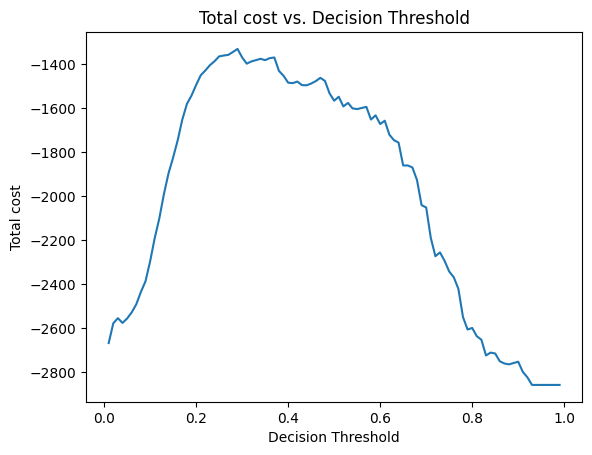

In [38]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2')


Decision Threshold: 0.01, Test cost/loss = -2438.50
Decision Threshold: 0.02, Test cost/loss = -2194.00
Decision Threshold: 0.03, Test cost/loss = -2041.00
Decision Threshold: 0.04, Test cost/loss = -1860.00
Decision Threshold: 0.05, Test cost/loss = -1764.00
Decision Threshold: 0.06, Test cost/loss = -1666.00
Decision Threshold: 0.07, Test cost/loss = -1582.00
Decision Threshold: 0.08, Test cost/loss = -1532.00
Decision Threshold: 0.09, Test cost/loss = -1521.50
Decision Threshold: 0.10, Test cost/loss = -1532.00
Decision Threshold: 0.11, Test cost/loss = -1496.00
Decision Threshold: 0.12, Test cost/loss = -1503.50
Decision Threshold: 0.13, Test cost/loss = -1573.50
Decision Threshold: 0.14, Test cost/loss = -1559.50
Decision Threshold: 0.15, Test cost/loss = -1547.50
Decision Threshold: 0.16, Test cost/loss = -1505.50
Decision Threshold: 0.17, Test cost/loss = -1485.50
Decision Threshold: 0.18, Test cost/loss = -1470.50
Decision Threshold: 0.19, Test cost/loss = -1440.50
Decision Thr

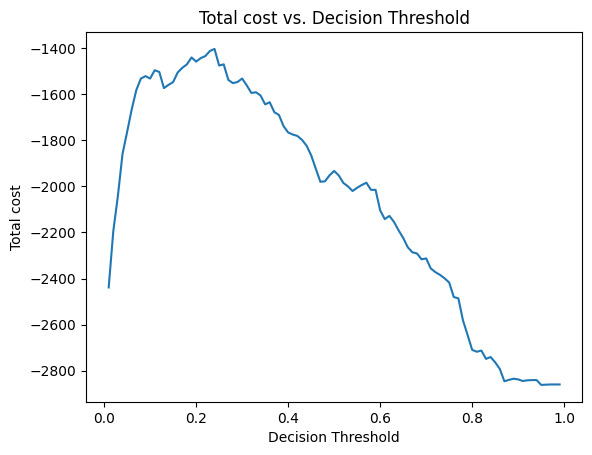

In [39]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud_2' )

# E-MP metric

In [40]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [41]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-2000.4371075707609
-2850.6690329385037
EAP :  -0.6492817616263424
EP :  -0.9252414907297968


In [42]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-2066.841611132186
-2850.6690329385037
EAP :  -0.67083466768328
EP :  -0.9252414907297968


In [43]:
len(test_predictions_log['FP'])


3081

In [44]:
test_predictions_log_2

,month,week_of_month,day_of_week,make,accident_area,day_of_week_claimed,month_claimed,week_of_month_claimed,sex,marital_status,age,fault,policy_type,vehicle_category,vehicle_price,fraud_found_p,rep_number,deductible,driver_rating,days_policy_accident,days_policy_claim,past_number_of_claims,age_of_vehicle,age_of_policy_holder,police_report_filed,witness_present,agent_type,number_of_suppliments,year,base_policy,number_of_cars_as_int,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
0,Jun,3,Friday,Ford,Rural,Friday,Jun,3,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,69000,0,15,400,1,30,30,1,7,36,No,No,External,0,1995,Collision,1,1,0,69000.0,0.0,1,0.772731,0,-34.5,-1,1,-0.772731,-0.059468
1,Mar,1,Tuesday,Pontiac,Urban,Monday,Mar,4,Male,Married,30,Policy Holder,Sedan - Collision,Sedan,30000,0,9,400,1,30,30,2,5,31,No,No,External,0,1995,Collision,1,1,0,30000.0,0.0,1,0.650338,0,-15.0,-1,1,-0.650338,-0.059468
2,Jul,3,Monday,Honda,Urban,Monday,Jul,3,Male,Married,39,Policy Holder,Sedan - Liability,Sport,20000,0,4,400,3,30,30,2,7,36,No,No,External,0,1994,Liability,1,0,0,20000.0,0.0,0,0.126620,0,-10.0,-1,1,-0.126620,-0.059468
3,Jan,4,Friday,Mazda,Urban,Friday,Jan,4,Female,Married,32,Policy Holder,Sedan - Collision,Sedan,30000,0,5,400,1,30,30,2,7,31,No,No,External,5,1995,Collision,1,0,0,30000.0,0.0,0,0.462978,0,-15.0,-1,1,-0.462978,-0.059468
4,Sep,2,Saturday,Pontiac,Urban,Sunday,Sep,3,Male,Married,27,Policy Holder,Sedan - Collision,Sedan,20000,0,8,400,1,30,30,0,7,31,No,No,External,0,1995,Collision,1,1,0,20000.0,0.0,1,0.661373,0,-10.0,-1,1,-0.661373,-0.059468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,Nov,2,Tuesday,Toyota,Urban,Wednesday,Nov,2,Male,Married,48,Policy Holder,Sedan - All Perils,Sedan,20000,1,9,400,4,30,30,1,7,41,No,No,External,0,1995,All Perils,1,1,1,20000.0,-10.0,1,0.775970,0,-10.0,-1,1,-1.464326,-9.345854
3054,May,4,Tuesday,Chevrolet,Urban,Friday,May,4,Male,Married,77,Policy Holder,Sedan - Collision,Sedan,20000,1,13,400,4,30,30,2,7,65,No,No,External,3,1996,Collision,1,0,1,20000.0,-10.0,0,0.499345,0,-10.0,-1,1,-4.507207,-9.345854
3057,Dec,2,Sunday,Mazda,Urban,Monday,Dec,2,Female,Married,33,Policy Holder,Sedan - Liability,Sport,20000,1,3,400,1,30,30,4,7,31,Yes,No,External,0,1995,Liability,1,0,1,20000.0,-10.0,0,0.107864,0,-10.0,-1,1,-8.813494,-9.345854
3080,Jun,2,Sunday,Accura,Urban,Wednesday,Jun,5,Male,Married,29,Policy Holder,Sedan - Collision,Sedan,30000,1,11,400,4,30,30,2,7,31,No,No,External,0,1994,Collision,1,1,1,30000.0,-15.0,1,0.734958,0,-15.0,-1,1,-3.240665,-14.048515


# cost-curves

In [45]:
len(test_predictions_log['FP'])

3081

In [46]:
total_fp_log = 0

for i in range(0,3081):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/3081
print( average_fp_log)

1079
0.350210970464135


In [47]:
total_fn_log = 0

for i in range(0,3081):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/3081
print( average_fn_log)

640.0
0.20772476468679


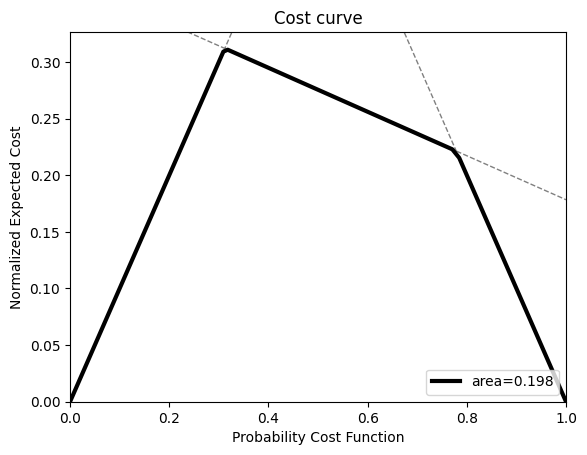

In [48]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [49]:
total_fp_xgb = 0

for i in range(0,3081):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/3081
print( average_fp_xgb)

517
0.16780266147354755


In [50]:
total_fn_xgb = 0

for i in range(0,3081):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/3081
print( average_fn_xgb)

1502.0
0.4875040571243103


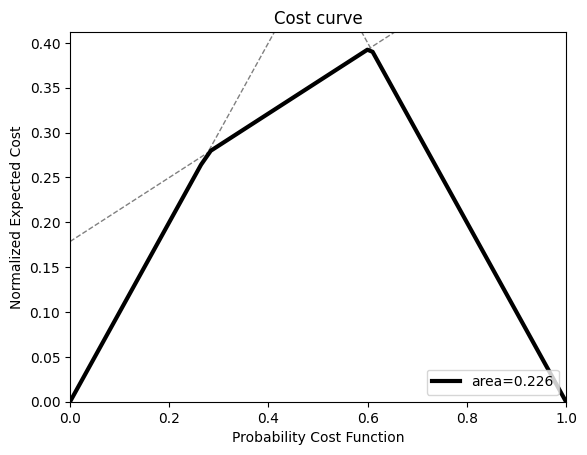

In [51]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the churn prediction cost and benefit matrices

# total cost at 50% threshold

In [52]:
test_predictions_log_churn = test.copy(deep=True)
test_predictions_log_churn["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn.drop(y, axis=1))
test_predictions_log_churn["churn_encoded"] = fit_le.transform(test_predictions_log_churn["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn['A'] = impute.fit_transform(
    (test["vehicle_price"]/2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn['instance_cost'] = test_predictions_log_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn['instance_cost'].sum()/len(test_predictions_log_churn))

Test cost/loss = 39529.
 total cost/loss average :  12.82992534891269


In [53]:
test_predictions_xgb_churn = test.copy(deep=True)
test_predictions_xgb_churn["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn.drop(y, axis=1))
test_predictions_xgb_churn["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn["fraud_found_p"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn['A'] = impute.fit_transform(
    (test_predictions_xgb["vehicle_price"]/2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb_churn['A'] = scaler.fit_transform(test_predictions_xgb_churn['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn['instance_cost'] = test_predictions_xgb_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_churn['instance_cost'].sum()/len(test_predictions_xgb_churn))

Test cost/loss = 32760.
 total cost/loss average :  10.632911392405063


# AMC metric

Decision Threshold: 0.01, Test cost/loss = 85264.00
Decision Threshold: 0.02, Test cost/loss = 82612.00
Decision Threshold: 0.03, Test cost/loss = 81690.00
Decision Threshold: 0.04, Test cost/loss = 81421.00
Decision Threshold: 0.05, Test cost/loss = 80570.00
Decision Threshold: 0.06, Test cost/loss = 79745.00
Decision Threshold: 0.07, Test cost/loss = 78660.00
Decision Threshold: 0.08, Test cost/loss = 77283.00
Decision Threshold: 0.09, Test cost/loss = 75501.00
Decision Threshold: 0.10, Test cost/loss = 73314.00
Decision Threshold: 0.11, Test cost/loss = 70617.00
Decision Threshold: 0.12, Test cost/loss = 67670.00
Decision Threshold: 0.13, Test cost/loss = 64571.00
Decision Threshold: 0.14, Test cost/loss = 61864.00
Decision Threshold: 0.15, Test cost/loss = 59236.00
Decision Threshold: 0.16, Test cost/loss = 56982.00
Decision Threshold: 0.17, Test cost/loss = 54175.00
Decision Threshold: 0.18, Test cost/loss = 52025.00
Decision Threshold: 0.19, Test cost/loss = 49834.00
Decision Thr

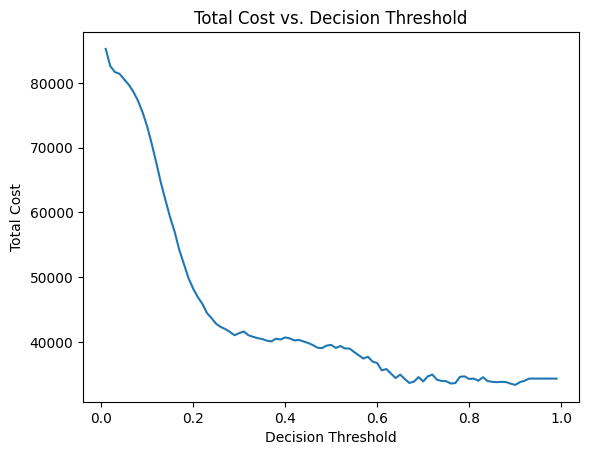

In [54]:
cb_column = 'A'
test_predictions_log_churn['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_churn, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn')

Decision Threshold: 0.01, Test cost/loss = 77202.00
Decision Threshold: 0.02, Test cost/loss = 68741.00
Decision Threshold: 0.03, Test cost/loss = 63269.00
Decision Threshold: 0.04, Test cost/loss = 58239.00
Decision Threshold: 0.05, Test cost/loss = 55430.00
Decision Threshold: 0.06, Test cost/loss = 52337.00
Decision Threshold: 0.07, Test cost/loss = 49829.00
Decision Threshold: 0.08, Test cost/loss = 47503.00
Decision Threshold: 0.09, Test cost/loss = 46405.00
Decision Threshold: 0.10, Test cost/loss = 45795.00
Decision Threshold: 0.11, Test cost/loss = 44641.00
Decision Threshold: 0.12, Test cost/loss = 43675.00
Decision Threshold: 0.13, Test cost/loss = 43444.00
Decision Threshold: 0.14, Test cost/loss = 42470.00
Decision Threshold: 0.15, Test cost/loss = 41477.00
Decision Threshold: 0.16, Test cost/loss = 40086.00
Decision Threshold: 0.17, Test cost/loss = 39310.00
Decision Threshold: 0.18, Test cost/loss = 38672.00
Decision Threshold: 0.19, Test cost/loss = 37698.00
Decision Thr

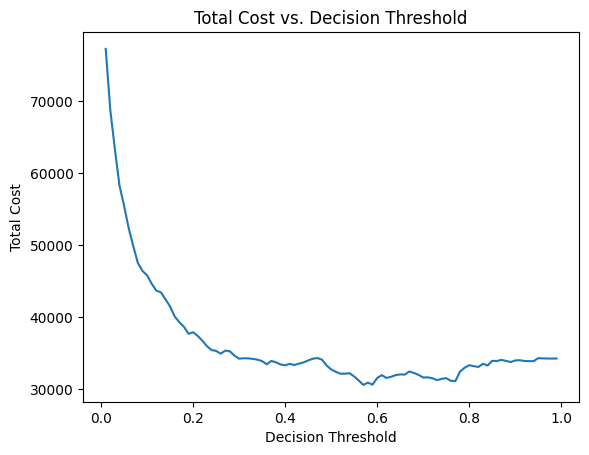

In [55]:
test_predictions_xgb_churn['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_churn, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn' )

# E-AMC metric

In [56]:
test_predictions_log_churn = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb_churn = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [57]:
print(test_predictions_log_churn['EAP'].sum())
print(test_predictions_log_churn['EP'].sum())


print('EAP : ', test_predictions_log_churn['EAP'].sum()/len(test_predictions_log_churn))
print('EP : ', test_predictions_log_churn['EP'].sum()/len(test_predictions_log_churn))

43930.32999471985
37402.10295310725
EAP :  14.258464782447207
EP :  12.139598491758276


In [58]:
print(test_predictions_xgb_churn['EAP'].sum())
print(test_predictions_xgb_churn['EP'].sum())


print('EAP : ', test_predictions_xgb_churn['EAP'].sum()/len(test_predictions_xgb_churn))
print('EP : ', test_predictions_xgb_churn['EP'].sum()/len(test_predictions_xgb_churn))

36611.04730651126
37357.43314944021
EAP :  11.882845604190607
EP :  12.125100016046805


# MP at 50% threshold

In [59]:
test_predictions_log_churn_2 = test.copy(deep=True)
test_predictions_log_churn_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn_2.drop(y, axis=1))
test_predictions_log_churn_2["churn_encoded"] = fit_le.transform(test_predictions_log_churn_2["fraud_found_p"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn_2['A'] = impute.fit_transform(
    (test_predictions_log_churn_2["vehicle_price"]/2000).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn_2['instance_cost'] = test_predictions_log_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn_2['instance_cost'].sum()/len(test_predictions_log_churn_2))

Test cost/loss = -35090.
 total cost/loss average :  -11.389159363842909


In [60]:
test_predictions_xgb_churn_2 = test.copy(deep=True)
test_predictions_xgb_churn_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn_2.drop(y, axis=1))
test_predictions_xgb_churn_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn_2["fraud_found_p"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn_2['A'] = impute.fit_transform(
    (test_predictions_xgb_churn_2["vehicle_price"]/2000).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn_2['instance_cost'] = test_predictions_xgb_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn_2[['fraud_found_p', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_churn_2['instance_cost'].sum()/len(test_predictions_xgb_churn_2))

Test cost/loss = -30919.
 total cost/loss average :  -10.03537812398572


# MP metric

Decision Threshold: 0.01, Test cost/loss = -79545.00
Decision Threshold: 0.02, Test cost/loss = -76893.00
Decision Threshold: 0.03, Test cost/loss = -75971.00
Decision Threshold: 0.04, Test cost/loss = -75771.00
Decision Threshold: 0.05, Test cost/loss = -74920.00
Decision Threshold: 0.06, Test cost/loss = -74095.00
Decision Threshold: 0.07, Test cost/loss = -73010.00
Decision Threshold: 0.08, Test cost/loss = -71633.00
Decision Threshold: 0.09, Test cost/loss = -69920.00
Decision Threshold: 0.10, Test cost/loss = -67733.00
Decision Threshold: 0.11, Test cost/loss = -65056.00
Decision Threshold: 0.12, Test cost/loss = -62178.00
Decision Threshold: 0.13, Test cost/loss = -59079.00
Decision Threshold: 0.14, Test cost/loss = -56392.00
Decision Threshold: 0.15, Test cost/loss = -53824.00
Decision Threshold: 0.16, Test cost/loss = -51590.00
Decision Threshold: 0.17, Test cost/loss = -48783.00
Decision Threshold: 0.18, Test cost/loss = -46633.00
Decision Threshold: 0.19, Test cost/loss = -44

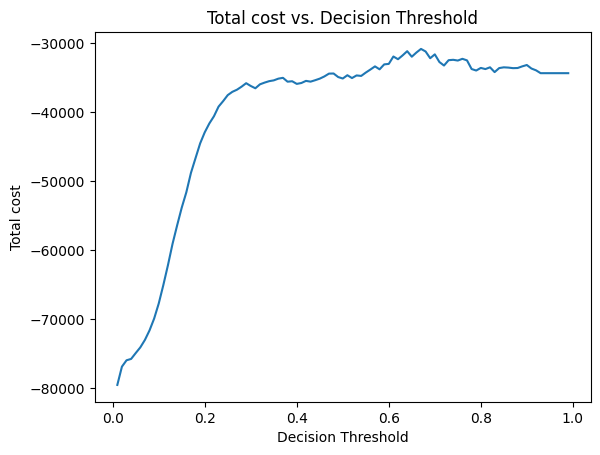

In [61]:
cb_column = 'A'
test_predictions_log_churn_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_churn_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn_2')


Decision Threshold: 0.01, Test cost/loss = -71939.00
Decision Threshold: 0.02, Test cost/loss = -64168.00
Decision Threshold: 0.03, Test cost/loss = -58717.00
Decision Threshold: 0.04, Test cost/loss = -53370.00
Decision Threshold: 0.05, Test cost/loss = -50471.00
Decision Threshold: 0.06, Test cost/loss = -47552.00
Decision Threshold: 0.07, Test cost/loss = -44857.00
Decision Threshold: 0.08, Test cost/loss = -42648.00
Decision Threshold: 0.09, Test cost/loss = -41608.00
Decision Threshold: 0.10, Test cost/loss = -40888.00
Decision Threshold: 0.11, Test cost/loss = -39822.00
Decision Threshold: 0.12, Test cost/loss = -39133.00
Decision Threshold: 0.13, Test cost/loss = -39521.00
Decision Threshold: 0.14, Test cost/loss = -38499.00
Decision Threshold: 0.15, Test cost/loss = -37645.00
Decision Threshold: 0.16, Test cost/loss = -36440.00
Decision Threshold: 0.17, Test cost/loss = -35722.00
Decision Threshold: 0.18, Test cost/loss = -35105.00
Decision Threshold: 0.19, Test cost/loss = -34

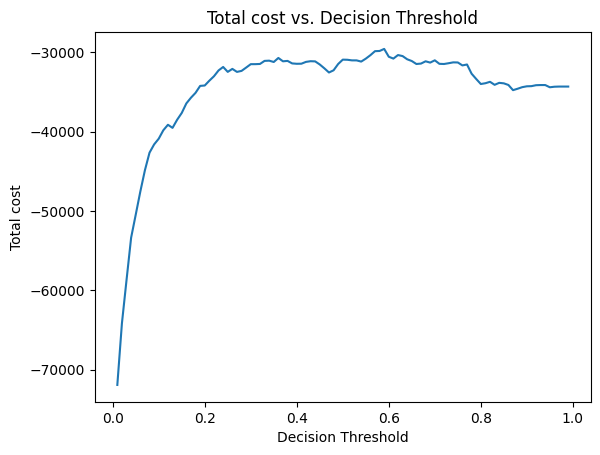

In [62]:
test_predictions_xgb_churn_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_churn_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2' )

# EMP-metric

In [63]:
test_predictions_log_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [64]:
print(test_predictions_log_churn_2['EAP'].sum())
print(test_predictions_log_churn_2['EP'].sum())


print('EAP : ', test_predictions_log_churn_2['EAP'].sum()/len(test_predictions_log_churn_2))
print('EP : ', test_predictions_log_churn_2['EP'].sum()/len(test_predictions_log_churn_2))

-40414.38034190054
-37062.00665260426
EAP :  -13.117293197630815
EP :  -12.029213454269476


In [65]:
print(test_predictions_xgb_churn_2['EAP'].sum())
print(test_predictions_xgb_churn_2['EP'].sum())


print('EAP : ', test_predictions_xgb_churn_2['EAP'].sum()/len(test_predictions_xgb_churn_2))
print('EP : ', test_predictions_xgb_churn_2['EP'].sum()/len(test_predictions_xgb_churn_2))

-34776.43062883592
-37062.00665260426
EAP :  -11.287384170345966
EP :  -12.029213454269476


# cost curves

In [66]:
total_fp_log_2 = 0

for i in range(0,3081):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 0 and test_predictions_log_churn['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_churn['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/3081
print( average_fp_log_2)

31849.0
10.33722817267121


In [67]:
total_fn_log_2 = 0

for i in range(0,3081):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 1 and test_predictions_log_churn['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_churn['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/3081
print( average_fn_log_2)

7680.0
2.4926971762414802


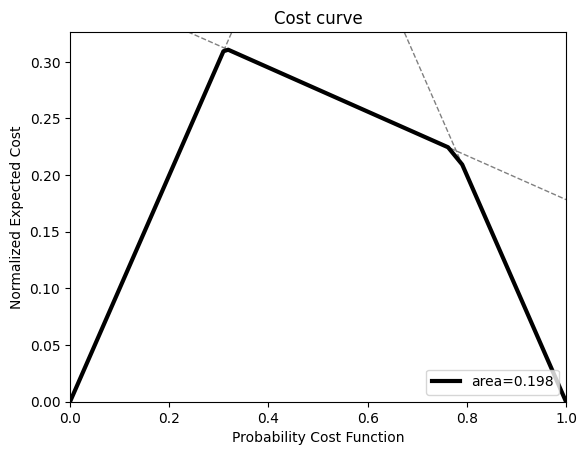

In [68]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [69]:
total_fp_xgb_2 = 0

for i in range(0,3081):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_churn['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_churn['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/3081
print( average_fp_xgb_2)

15312.0
4.9698149951314505


In [70]:
total_fn_xgb_2 = 0

for i in range(0,3081):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_churn['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_churn['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/3081
print( average_fn_xgb_2)

17448.0
5.663096397273613


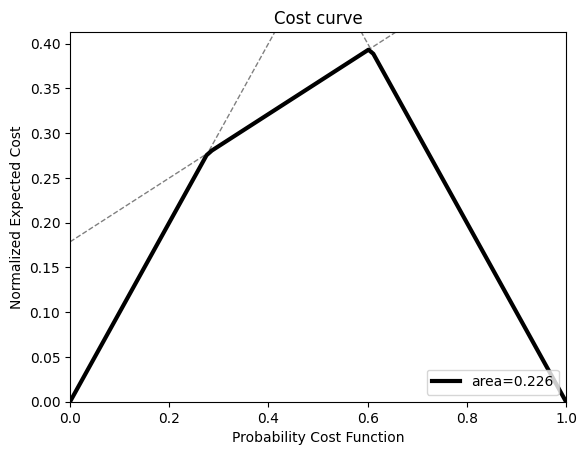

In [71]:
# C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()